In [1]:
# Modules for structuring text
from typing import Annotated
from typing_extensions import TypedDict

# LangGraph modules for defining graphs
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# Module for setting up OpenAI
# from langchain_openai import ChatOpenAI



In [2]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.0-flash", model_provider="google_genai")

## Building graph and agent states


In [3]:
# Define the State
class State(TypedDict):
    # Define messages with metadata    
    messages: Annotated[list, add_messages]
# Initialize StateGraph
graph_builder = StateGraph(State)


Adding nodes and edges

In [4]:
# Define chatbot function to respond# with the model
def chatbot(state: State):
    response = llm.invoke(state["messages"])
    return {"messages":  [response]}
# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

## Connect the graph nodes: START -> chatbot -> END
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# Compile the graph
graph = graph_builder.compile()


In [ ]:
graph.invoke({"messages": ["Hello, my name is Trung Thao. How are you?"]})
graph.invoke({"messages": ["Can you tell my name?"]})

{'messages': [HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='7b6b05bf-7e8d-4b5d-8fab-da8d6c22c211'),
  AIMessage(content='I am doing well, thank you for asking! How are you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--aef54fea-6327-4cba-ab38-f97519080f69-0', usage_metadata={'input_tokens': 6, 'output_tokens': 16, 'total_tokens': 22, 'input_token_details': {'cache_read': 0}})]}

## Streaming LLM responses


In [24]:
def stream_graph_updates(user_input: str):
    # Start streaming events from the graph with the user's input
    for event in graph.stream({"messages": [("user", user_input)]}):
        # Retrieve and print the chatbot node responses
        for value in event.values():
            print("Agent:", value["messages"], end="|")

# Define the user query and run the chatbot
user_query = "Who is Dinh Trung Thao?"
stream_graph_updates(user_query)

Agent: [AIMessage(content="Dinh Trung Thao is a Vietnamese politician. He is currently the Vice Chairman of the Standing Committee of the National Assembly of Vietnam. He is also a member of the Communist Party of Vietnam's Central Committee.", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--c3f593ce-261a-4ae1-b990-ff8f57fd50c0-0', usage_metadata={'input_tokens': 8, 'output_tokens': 44, 'total_tokens': 52, 'input_token_details': {'cache_read': 0}})]|

## Generate a LangGraph diagram


In [25]:
from IPython.display import Image, display
# Try generating and displaying # the graph diagram
try:    
    display(Image(graph.get_graph().draw_mermaid_png()))
    # Return an exception if necessary  
except Exception:
    print("Additional dependencies required.")


KeyboardInterrupt: 

# Adding external tools to a chatbot

Adding a Wikipedia tool

In [6]:
%pip install wikipedia
%pip install langchain-community

from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools import WikipediaQueryRun

# Initialize Wikipedia API wrapper to fetch top 1 result
api_wrapper = WikipediaAPIWrapper(top_k_results=1)
# Create a Wikipedia query tool using the API wrapper

wikipedia_tool = WikipediaQueryRun(api_wrapper=api_wrapper)
tools = [wikipedia_tool]

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [22]:
# Bind the Wikipedia tool to 
# the language model
llm_with_tools = llm.bind_tools(tools)

# Modify chatbot function to respond with Wikipedia
def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    return {"messages": [response]}

## Adding tool nodes



In [35]:
#Modules for adding tool conditions # and nodes
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder = StateGraph(State)

# Add chatbot node to the graph
graph_builder.add_node("chatbot", chatbot)

In [36]:
# Create a ToolNode to handle tool calls # and add it to the graph
tool_node = ToolNode(tools=[wikipedia_tool])
graph_builder.add_node("tools", tool_node)

### Add conditional edge

In [37]:
# Set up a condition to direct from chatbot to tool or end node
graph_builder.add_conditional_edges("chatbot", tools_condition)

In [38]:
# Connect tools back to chatbot and  add START and END nodes
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)


In [39]:
graph = graph_builder.compile()

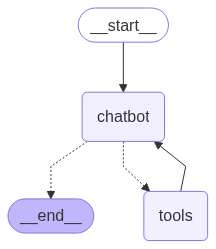

In [40]:
from IPython.display import Image, display
# Try generating and displaying # the graph diagram
try:    
    display(Image(graph.get_graph().draw_mermaid_png()))
    # Return an exception if necessary  
except Exception:
    print("Additional dependencies required.")


In [41]:
def stream_tool_responses(user_input: str):
    # Start streaming events from the graph with the user's input
    for event in graph.stream({
            "messages": [("user", user_input)],
            
        }):
        # Retrieve and print the chatbot node responses
        for value in event.values():
            print("Agent:", value["messages"], end="\n")

In [42]:
user_query = "House of Lords"
stream_tool_responses(user_query)


Agent: [AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "House of Lords"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--2e1f3ee3-c180-4e89-8329-6ff8f98f806c-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'House of Lords'}, 'id': 'de8bf1d1-785d-49dd-a010-b55900767bd3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 51, 'output_tokens': 5, 'total_tokens': 56, 'input_token_details': {'cache_read': 0}})]
Agent: [ToolMessage(content='Page: House of Lords\nSummary: The House of Lords is the upper house of the Parliament of the United Kingdom. Like the lower house, the House of Commons, it meets in the Palace of Westminster in London, England. One of the oldest extant institutions in the world, its origins lie in the early 11th century and the emergence of bicameralism in the 13th century.\nIn

In [43]:
user_query = "Hung King"
stream_tool_responses(user_query)

Agent: [AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "Hung King"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--8e50951d-866e-4ca7-885e-12c213c0f2df-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Hung King'}, 'id': '9415c699-8df6-40e3-b0b3-26e57d26b365', 'type': 'tool_call'}], usage_metadata={'input_tokens': 50, 'output_tokens': 4, 'total_tokens': 54, 'input_token_details': {'cache_read': 0}})]
Agent: [ToolMessage(content='Page: Hùng king\nSummary: Hùng king (2879 BC – 258 BC; Chữ Hán: 雄王; Vietnamese: Hùng Vương (雄王) or vua Hùng (𤤰雄); Vương means "king" and vua means "monarch; could mean emperor or king") is the title given to the ancient Vietnamese rulers of the Hồng Bàng period.', name='wikipedia', id='8fd189de-cdd2-4930-bb61-5dc0793a0512', tool_call_id='9415c699-8df6-40e3-b0b3-26e57d26b3

## Adding memory

In [49]:
# Import the modules for saving memory
from langgraph.checkpoint.memory import MemorySaver
# Modify the graph with memory checkpointing
memory = MemorySaver()  # Compile the graph passing in memory
graph = graph_builder.compile(checkpointer=memory)
# graph = graph_builder.compile()


In [48]:
# Set up a streaming function for a single user
def stream_memory_responses(user_input: str):    
    config = {"configurable": {"thread_id": "single_session_memory"}}
    # Stream the events in the graph
    for event in graph.stream({"messages": [("user", user_input)]}, config):
        # Return the agent's last response
        for value in event.values():
            if "messages"in value and value["messages"]:
                print("Agent:", value["messages"])
                
stream_memory_responses("What is the Colosseum?")

stream_memory_responses("Who built it?")


Agent: [AIMessage(content='', additional_kwargs={'function_call': {'name': 'wikipedia', 'arguments': '{"query": "Colosseum"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--0b090ec9-fa61-492e-a50c-e374da047684-0', tool_calls=[{'name': 'wikipedia', 'args': {'query': 'Colosseum'}, 'id': 'c575cddc-7e9b-4aa5-8cfb-030fe01dff2d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 54, 'output_tokens': 4, 'total_tokens': 58, 'input_token_details': {'cache_read': 0}})]
Agent: [ToolMessage(content='Page: Colosseum\nSummary: The Colosseum ( KOL-ə-SEE-əm; Italian: Colosseo [kolosˈsɛːo], ultimately from Ancient Greek word "kolossos" meaning a large statue or giant) is an elliptical amphitheatre in the centre of the city of Rome, Italy, just east of the Roman Forum. It is the largest ancient amphitheatre ever built, and is still the largest standing amphitheatre in the 

# Build Dynamic Chat Agents


## Define multiple tools
### Historical events tool

In [ ]:
from langchain.tools import tool

# Use a decorator to label the tool and set the input format to string
@tool
def date_checker(date: str) -> str:
    """Provide a list of important historical events for a given date in any format."""
    try:
        # Invoke the LLM to interpret the date and generate historical events        
        answer = llm.invoke(f"List important historical events that occurred on {date}.")
        
        # Return the response
        return answer.content
    # Set an exception block for errors in retrieval
    except Exception as e:
        return f"Error retrieving events: {str(e)}"


In [54]:
@tool
# Set input format to string
def check_palindrome(text: str):
    """Check if a word or phrase is a palindrome."""
    # Remove non-alphanumeric characters and convert to lowercase    
    cleaned = ''.join(char.lower() for char in text if char.isalnum())
    # Check if the reversed text is the same as original text
    if cleaned == cleaned[::-1]:
        return f"The phrase or word '{text}' is a palindrome."
    else:
        return f"The phrase or word '{text}' is not a palindrome."


### Binding multiple tools


In [55]:
# Import modules required for defining tool nodes
from langgraph.prebuilt import ToolNode
# List of tools
tools = [wikipedia_tool, date_checker, check_palindrome] 
# Pass the tools to the ToolNode()

tool_node = ToolNode(tools)
# Bind tools to the LLM
model_with_tools = llm.bind_tools(tools)

<div style="display: flex; gap: 2em;">

<div style="flex: 1;">

## Define workflow functions
- Create a stop function between chatbot and tools
    - Check for tool calls
    - End conversation if none
- Create a dynamic tool caller
    - Return a tool response if tool call present
    - Invoke the LLM with just the chatbotnode if no tool calls
- Compile the full graph

</div>

<div style="flex: 1;">

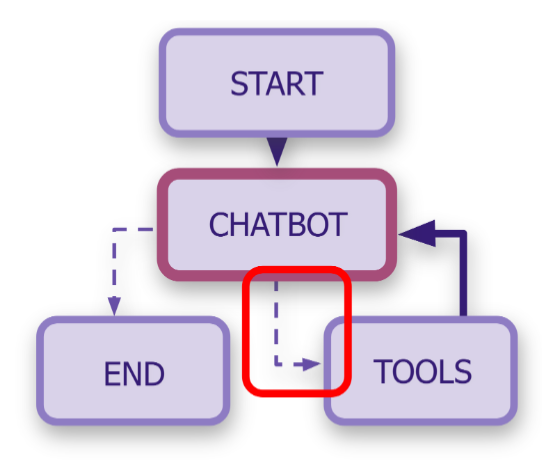

</div>
</div>


### Create stop function

In [ ]:
from langgraph.graph import MessagesState, START, END
# Use MessagesState to define the state of the stopping function
def should_continue(state: MessagesState):
    # Get the last message from the state 
    last_message = state["messages"][-1]
    # Check if the last message includes tool calls
    if last_message.tool_calls:
        return "tools" 
    # End the conversation if no tool calls are present
    return END




### Create a dynamic tool caller

In [57]:
from langgraph.graph import MessagesState
from langchain.schema import AIMessage

# Extract the last message from the history
def call_model(state: MessagesState):
    last_message = state["messages"][-1]
    
    # If the last message has tool calls, return the tool's response
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        # Return the messages from the tool call
        return { "messages": [AIMessage(content=last_message.tool_calls[0]["response"])] }
    
    # Otherwise, proceed with a regular LLM response
    return { "messages": [model_with_tools.invoke(state["messages"])] }


### Create the graph

In [59]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import MessagesState

workflow = StateGraph(MessagesState)

# Add nodes for chatbot and tools
workflow.add_node("chatbot", call_model)
workflow.add_node("tools", tool_node)

# Connect the START node to the chatbot
workflow.add_edge(START, "chatbot")

# Define conditions, then loop back to chatbot
workflow.add_conditional_edges("chatbot", should_continue, ["tools", END])

workflow.add_edge("tools", "chatbot")

# Set up memory and compile the workflow
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)



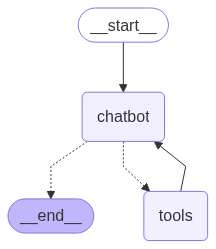

In [60]:
display(Image(app.get_graph().draw_mermaid_png()))

### Streaming multiple tool outputs


In [62]:
from langchain_core.messages import AIMessage, HumanMessage
config = { "configurable": {"thread_id": "1"} }
# Create input message with the user's query
def multi_tool_output(query): 
    inputs = {"messages": [HumanMessage(content=query)]}
    
    # Stream messages and metadata from the chatbot application    
    for msg, metadata in app.stream(inputs, config, stream_mode="messages"):
        # Check if the message has content and is not from a human
        if msg.content and not isinstance(msg, HumanMessage):
            print(msg.content, end="", flush=True)
            print("\n")


### Test with multiple tools

In [63]:
multi_tool_output("Is `Stella won no wallets` a palindrome?")
multi_tool_output("What happened on April 12th, 1955?")


The phrase or word 'Stella won no wallets' is a palindrome.

Yes, 

`Stella won no wallets` is a palindrome.


The

 most significant historical event that occurred on April 12th, 195

5 was:

*   **The announcement that the Salk polio vaccine was

 safe and effective.** This was a monumental moment in medical history, as polio had been a devastating disease, particularly affecting children. The announcement sparked widespread celebration and relief

.

While the Salk vaccine announcement overshadows everything else, it's worth noting that other events may have occurred on that date, but they are less

 globally significant.


The most significant historical event that occurred on April 12th, 1955 was:

*   **The announcement that the Salk polio vaccine was safe and effective.** This was a monumental moment in medical history, as polio had been a devastating disease, particularly affecting children. The announcement sparked widespread celebration and relief.

While the Salk vaccine ann

### Follow-up questions with multiple tools


In [66]:
# Print the user query first for every interaction
def user_agent_multiturn(queries):
    for query in queries:
        print(f"User: {query}")
    
        # Stream through messages corresponding to queries, excluding metadata 
        contents = []
        for msg, metadata in app.stream(
            {"messages": [HumanMessage(content=query)]}, config, stream_mode="messages"
        ):
            # Collect the content of the messages
            if msg.content and not isinstance(msg, HumanMessage):
                contents.append(msg.content)
        # Print the agent's response
        print("Agent: " + "".join(contents) + "\n")
    



In [67]:
queries = ["What happened on the 12 April 1961?", "What about 10 December 1948?", 
           "Is `Mr. Owl ate my metal worm?` a palindrome?", "What about 'palladium stadium?'"]
user_agent_multiturn(queries)

User: What happened on the 12 April 1961?
Agent: The single most important historical event that occurred on April 12, 1961, was:

*   **Yuri Gagarin became the first human in space.** He completed one orbit of the Earth in the Vostok 1 spacecraft, a monumental achievement in the Space Race between the Soviet Union and the United States.

While this event overshadows everything else that happened on that day, there likely were other events of local or regional significance. However, Gagarin's flight is the defining event of April 12, 1961.
The single most important historical event that occurred on April 12, 1961, was:

*   **Yuri Gagarin became the first human in space.** He completed one orbit of the Earth in the Vostok 1 spacecraft, a monumental achievement in the Space Race between the Soviet Union and the United States.

While this event overshadows everything else that happened on that day, there likely were other events of local or regional significance. However, Gagarin's fligh